# Robotics, Vision & Control 3e: for Python
## Chapter 14: Using Multiple Images

In [180]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install 'matplotlib>=3.6'
    !pip install machinevision-toolbox-python
    !pip install rvc3python
    COLAB = True
except:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

import RVC3 as rvc
sys.path.append(os.path.join(rvc.__path__[0], 'examples'))

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from machinevisiontoolbox.base import *
from machinevisiontoolbox import *
from spatialmath.base import *
from spatialmath import *


# 14.1 Point Feature Correspondence


In [181]:
view1 = Image.Read("eiffel-1.png", mono=True)
view2 = Image.Read("eiffel-2.png", mono=True)

Image: 1280 x 960 (uint8) [.../images/eiffel-2.png]

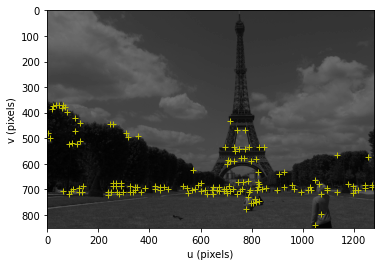

In [182]:
hf = view1.Harris(nfeat=150)
view1.disp(block=None, darken=True); hf.plot();

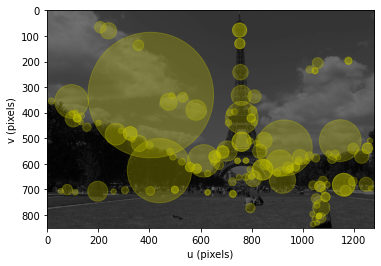

In [183]:
sf = view1.SIFT().sort().filter(minscale=10)[:150]
view1.disp(block=None, darken=True); sf.plot(filled=True, color="y", alpha=0.3)

In [184]:
hf[0].descriptor.shape

(121,)

In [185]:
hf[0].distance(hf[1], metric="ncc")

array([[  0.5908]])

In [186]:
sf[0].descriptor.shape

(128,)

In [187]:
sf[0].distance(sf[1], metric="L2")

array([[   484.1]])

In [188]:
sf1 = view1.SIFT()
sf2 = view2.SIFT()

SIFTFeature features, 3028 points

In [189]:
matches = sf1.match(sf2);
len(matches)

860

In [190]:
matches[:5].list()

  0:    24.00 (1118.6, 178.7) <--> (952.5, 417.9)
  1:    24.12 (900.2, 636.6) <--> (775.6, 802.3)
  2:    25.81 (760.3, 125.0) <--> (656.2, 369.1)
  3:    27.33 (820.5, 519.0) <--> (708.0, 701.6)
  4:    28.12 (801.1, 632.4) <--> (694.1, 800.3)


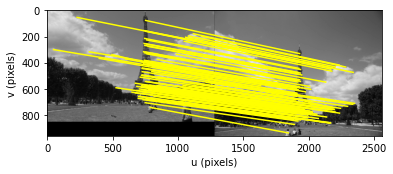

In [191]:
matches.subset(100).plot(color="yellow", block=None)

In [192]:
c = matches.correspondence();
c[:, :5]

array([[2890, 2467, 1661, 2218, 2081],
       [2258, 1945, 1412, 1773, 1705]])

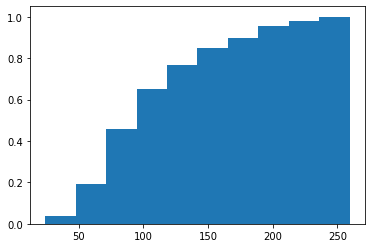

In [193]:
plt.hist(matches.distance, cumulative=True, density=True);

In [194]:
m = sf1.match(sf2, thresh=20);

In [195]:
m = sf1.match(sf2, sort=True)[:10];

In [196]:
m = sf1.match(sf2, ratio=0.8)

951 matches

In [197]:
m = sf1.match(sf2, crosscheck=True)

1372 matches

# 14.2 Geometry of Multiple Views


In [198]:
camera1 = CentralCamera(name="camera 1", f=0.002, imagesize=1000, 
                        rho=10e-6, pose=SE3.Tx(-0.1)*SE3.Ry(0.4))

           Name: camera 1 [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1000 x 1000
           pose: t = -0.1, 0, 0; rpy/yxz = 0°, 0°, 22.9°
   principal pt: [     500      500]
   focal length: [   0.002    0.002]

In [199]:
camera2 = CentralCamera(name="camera 2", f=0.002, imagesize=1000, 
                        rho=10e-6, pose=SE3.Tx(0.1)*SE3.Ry(-0.4))

           Name: camera 2 [CentralCamera]
     pixel size: 1e-05 x 1e-05
     image size: 1000 x 1000
           pose: t = 0.1, 0, 0; rpy/yxz = 0°, 0°, -22.9°
   principal pt: [     500      500]
   focal length: [   0.002    0.002]

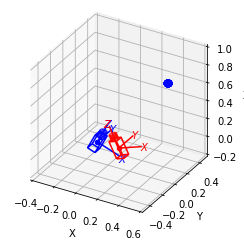

In [200]:
ax = plotvol3([-0.4, 0.6, -0.5, 0.5, -0.2, 1]);
camera1.plot(ax=ax, scale=0.15, shape="camera", frame=True, color="blue");
camera2.plot(ax=ax, scale=0.15, shape="camera", frame=True, color="red");
P=[0.5, 0.1, 0.8];
plot_sphere(0.03, P, color="blue");

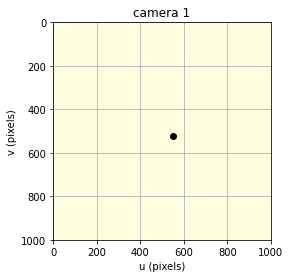

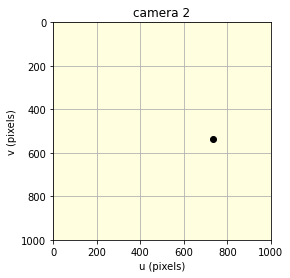

array([[     734],
       [   534.4]])

In [201]:
p1 = camera1.plot_point(P)
p2 = camera2.plot_point(P)

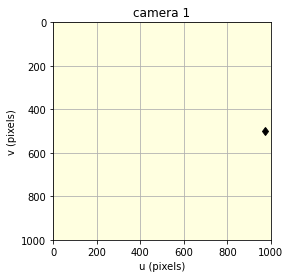

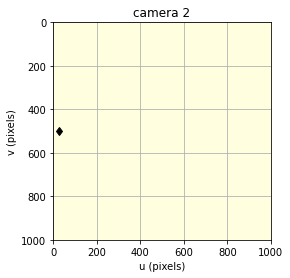

array([[   26.96],
       [     500]])

In [202]:
e1 = camera1.plot_point(camera2.centre, "kd")
e2 = camera2.plot_point(camera1.centre, "kd")

## 14.2.1 The Fundamental Matrix


In [203]:
F = camera1.F(camera2)

array([[       0, -1.947e-06, 0.0009735],
       [-1.947e-06,        0, 0.001895],
       [0.0009735, 5.248e-05,  -0.9735]])

In [204]:
e2h(p2).T @ F @ e2h(p1)

array([[       0]])

In [205]:
e2h

<function spatialmath.base.transformsNd.e2h(v)>

In [206]:
np.linalg.matrix_rank(F)

2

In [207]:
e1h = sp.linalg.null_space(F);
e1h.T

array([[  0.8894,    0.457, 0.0009141]])

In [208]:
e1 = h2e(e1h)

array([[     973],
       [     500]])

In [209]:
e2h = sp.linalg.null_space(F.T);
e2 = h2e(e2h)

array([[   26.96],
       [     500]])

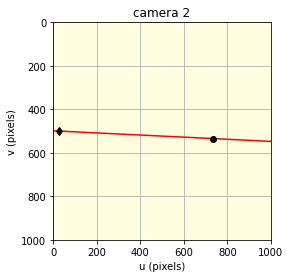

In [210]:
plt.clf()
with plt.ioff():
    camera2.plot_epiline(F, p1, color="red");
    camera2.plot_point(camera1.centre, "kd");  # show the epipole
    camera2.plot_point(P);                     # show the point

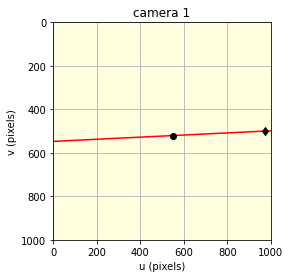

In [211]:
plt.clf()
with plt.ioff():
    camera1.plot_epiline(F.T, p2, color="red");
    camera1.plot_point(camera2.centre, "kd");  # show the epipole
    camera1.plot_point(P);                     # show the point


## 14.2.2 The Essential Matrix


In [212]:
E = camera1.E(F)

array([[       0, -0.07788,        0],
       [-0.07788,        0,   0.1842],
       [       0,  -0.1842,        0]])

In [213]:
T_1_2 = camera1.decomposeE(E);
T_1_2.printline(orient="camera")

t = -0.921, 0, -0.389; rpy/yxz = 0°, 0°, -45.8°
t = 0.921, 0, 0.389; rpy/yxz = 0°, 0°, -45.8°
t = -0.921, 0, -0.389; rpy/yxz = 180°, 0°, 180°
t = 0.921, 0, 0.389; rpy/yxz = 180°, 0°, 180°


In [214]:
T_1_2_true = camera1.pose.inv() * camera2.pose;
T_1_2_true.printline(orient="camera")

t = 0.184, 0, 0.0779; rpy/yxz = 0°, 0°, -45.8°


In [215]:
T_1_2_true.t / np.linalg.norm(T_1_2_true.t)

array([  0.9211,        0,   0.3894])

In [216]:
Q = [0, 0, 10];

In [217]:
camera1.project_point(Q).T

array([[   417.8,      500]])

In [218]:
for T in T_1_2:
 print(camera1.project_point(Q, pose=T).T)

[[   746.1      500]]
[[     670      500]]
[[     nan      nan]]
[[     nan      nan]]


In [219]:
T = camera1.decomposeE(E, Q);
T.printline(orient="camera")

t = -0.921, 0, -0.389; rpy/yxz = 0°, 0°, -45.8°


## 14.2.3 Estimating the Fundamental Matrix from Real Image Data


In [220]:
P = np.random.uniform(low=-1, high=1, size=(3, 10)) + np.c_[0, 0, 3].T;

In [221]:
p1 = camera1.project_point(P);
p2 = camera2.project_point(P);

In [222]:
F, resid = CentralCamera.points2F(p1, p2)
resid

1.3102964033825238e-07

In [223]:
np.linalg.matrix_rank(F)

2

False


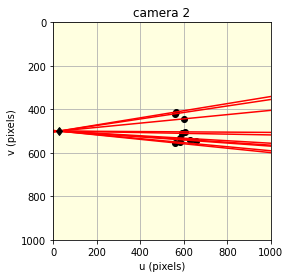

In [224]:
plt.clf()
with plt.ioff():
    camera2.plot_point(P);
    print(plt.isinteractive())
    camera2.plot_epiline(F, p1, color="red")
    camera2.plot_point(camera1.centre, "kd")

In [225]:
p2[:,[5, 6]] = p2[:,[6, 5]];

In [226]:
_, resid = CentralCamera.points2F(p1, p2);
resid

0.007142966331037329

In [227]:
CentralCamera.epidist(F, p1[:, 0], p2[:,0])
CentralCamera.epidist(F, p1[:, 5], p2[:,5])

array([[   34.82]])

In [228]:
F, resid, inliers = CentralCamera.points2F(p1, p2, method="ransac", 
                                           confidence=0.99, seed=0);
resid

1.540248393970562e-07

In [229]:
inliers

array([ True,  True,  True,  True,  True, False, False,  True,  True,  True])

In [230]:
F, resid, inliers = CentralCamera.points2F(matches.p1, matches.p2, 
                                           method="ransac", confidence=0.99);
resid
sum(inliers) / len(inliers)

0.8244186046511628

In [231]:

sum(~inliers)

151

In [232]:
F, resid = matches.estimate(CentralCamera.points2F, method="ransac", 
                            confidence=0.99, seed=0);

In [233]:
matches
matches[:10].list()

  0:  +  24.00 (1118.6, 178.7) <--> (952.5, 417.9)
  1:  +  24.12 (900.2, 636.6) <--> (775.6, 802.3)
  2:  +  25.81 (760.3, 125.0) <--> (656.2, 369.1)
  3:  +  27.33 (820.5, 519.0) <--> (708.0, 701.6)
  4:  +  28.12 (801.1, 632.4) <--> (694.1, 800.3)
  5:  +  29.33 (1094.0, 184.7) <--> (932.9, 423.0)
  6:  +  31.06 (781.0, 214.4) <--> (672.8, 443.8)
  7:  +  33.60 (1094.0, 184.7) <--> (932.9, 423.0)
  8:  +  33.70 (526.5, 484.2) <--> (462.4, 673.6)
  9:  +  33.79 (759.7, 332.0) <--> (655.9, 543.0)


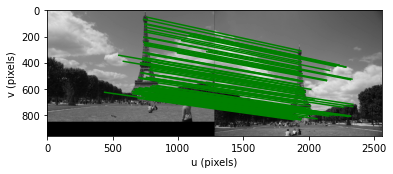

In [234]:
matches.inliers.subset(100).plot(color="g", block=None);

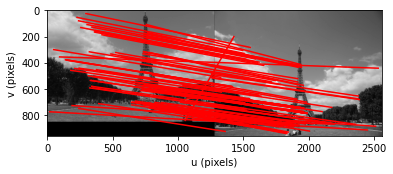

In [235]:
matches.outliers.subset(100).plot(color="red")

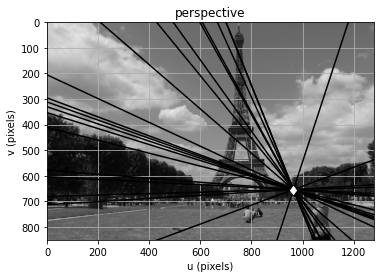

In [236]:
camera = CentralCamera();
with plt.ioff():
    camera.disp(view1, block=None);
    camera.plot_epiline(F.T, matches.inliers.subset(20).p2, color="black");
    epipole = h2e(sp.linalg.null_space(F))
    camera.plot_point(epipole, "wd");


#### Excurse 14.3

[6, 8, 0, 1, 5, 7, 10]

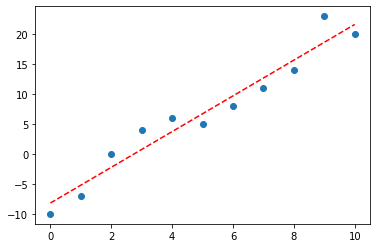

In [237]:
import scipy as sp
!pip install rvc3python==0.2.3
from RVC3.examples import ransac_line

x = np.arange(11);
y = 3 * x - 10;
nbad = 4;
np.random.seed(1)  # set the random number generator seed
bad = np.random.choice(len(x), nbad, replace=False)
y[bad] = y[bad] + np.random.rand(nbad) * 10
plt.plot(x, y, 'o')

m, c, *_ = sp.stats.linregress(x, y)
plt.plot(x, m * x + c, 'r--');
params, inliers = ransac_line.ransac_line(x, y)
params
inliers


## 14.2.4 Planar Homography


In [238]:
T_grid = SE3.Tz(1) * SE3.Rx(0.1) * SE3.Ry(0.2);
P = mkgrid(3, 1.0, pose=T_grid);

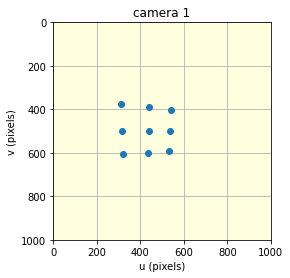

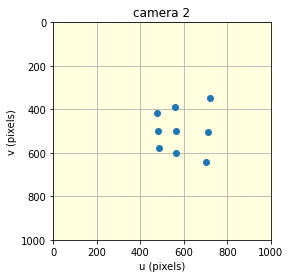

In [239]:
p1 = camera1.plot_point(P, "o");
p2 = camera2.plot_point(P, "o");

In [240]:
H, resid = CentralCamera.points2H(p1, p2)
H

array([[ -0.4187, -0.0003935,    397.8],
       [ -0.6981,   0.3738,    309.5],
       [-0.001396, -1.459e-05,        1]])

In [241]:
p2b = homtrans(H, p1);

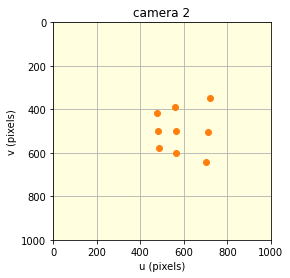

In [242]:
with plt.ioff():
    camera2.plot_point(p2b, "+");
    camera2.plot_point(P, "o");  # show original points

In [243]:
p1b = homtrans(np.linalg.inv(H), p1);

In [244]:
Q = np.array([
  [-0.2302,   -0.0545,    0.2537],
  [ 0.3287,    0.4523,    0.6024],
  [ 0.4000,    0.5000,    0.6000] ]);

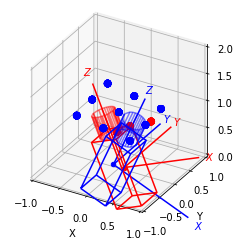

In [245]:
plotvol3([-1, 1, -1, 1, 0, 2]);
plot_sphere(0.05, P, color="blue");
plot_sphere(0.05, Q, color="red");
camera1.plot(color="blue", frame=True);
camera2.plot(color="red", frame=True);

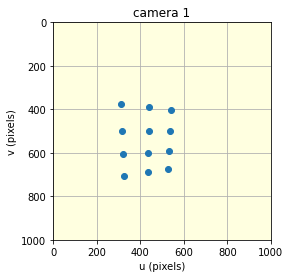

In [246]:
p1 = camera1.plot_point(np.hstack((P, Q)), "o");

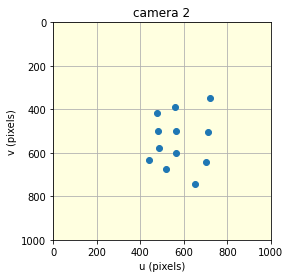

In [247]:
p2 = camera2.plot_point(np.hstack((P, Q)), "o");

In [248]:
p2h = homtrans(H, p1);

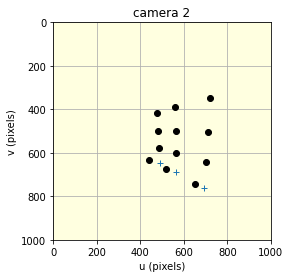

In [249]:
with plt.ioff():
    camera2.plot_point(p2h, "+");
    camera2.plot_point(p2);    # show projected points


In [250]:
np.linalg.norm(homtrans(H, p1) - p2, axis=0)

array([1.262e-05, 9.673e-06, 6.544e-07, 8.302e-06, 4.34e-06, 1.189e-05, 1.679e-05, 5.884e-06, 3.927e-05,     50.6,
          46.44,    45.38])

In [251]:
H, resid, inliers = CentralCamera.points2H(p1, p2, method="ransac");
resid
inliers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False])

In [252]:
T, normals = camera1.decomposeH(H);
T.printline(orient="camera")

t = -0.185, 0, -0.0783; rpy/yxz = -8.39e-06°, 4.61e-06°, -45.8°
t = 0.185, 0, 0.0783; rpy/yxz = -8.39e-06°, 4.61e-06°, -45.8°
t = 0.0197, 0.0192, -0.199; rpy/yxz = 1.09°, 0.338°, -34.4°
t = -0.0197, -0.0192, 0.199; rpy/yxz = 1.09°, 0.338°, -34.4°


In [253]:
(camera1.pose.inv() * camera2.pose).printline(orient="camera")

t = 0.184, 0, 0.0779; rpy/yxz = 0°, 0°, -45.8°


In [254]:
camera1.pose.inv() * T_grid

   0.9797   -0.03888  -0.1968   -0.2973    
   0.01983   0.995    -0.09784   0         
   0.1996    0.09195   0.9756    0.96      
   0         0         0         1         


In [255]:
normals[1].T

array([[ -0.1968, -0.09784,   0.9756]])

In [256]:
walls_l = Image.Read("walls-l.png", reduce=2);
walls_r = Image.Read("walls-r.png", reduce=2);

In [257]:
sf_l = walls_l.SIFT();
sf_r = walls_r.SIFT();

In [258]:
matches = sf_l.match(sf_r);

In [259]:
H, resid = matches.estimate(CentralCamera.points2H, confidence=0.9, seed=0)
matches

2797 matches, with 967 (34.6%) inliers

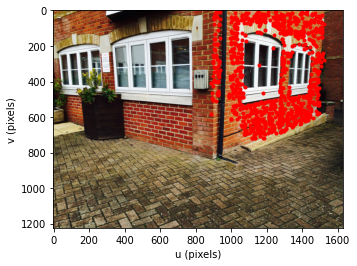

In [260]:
walls_l.disp(block=None);
plot_point(matches.inliers.p1, "r.");

In [261]:
not_plane = matches.outliers;

# 14.3 Sparse Stereo


## 14.3.1 3D Triangulation


In [262]:
matches = sf_l.match(sf_r)
F, resid = matches.estimate(CentralCamera.points2F, confidence=0.99, seed=0);

In [263]:
matches = matches.inliers  # keep only the inliers

2389 matches, with 2389 (100.0%) inliers

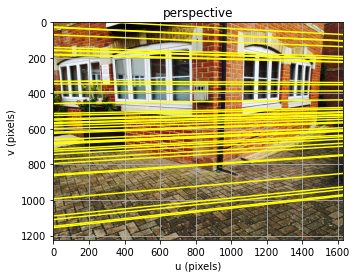

In [264]:
camera = CentralCamera();
camera.disp(walls_l, block=None);
camera.plot_epiline(F.T, matches.subset(40).p2, "yellow");

In [265]:
f = walls_l.metadata("FocalLength")

4.15

In [266]:
name = walls_l.metadata("Model")

'iPhone 5s'

In [267]:
camera = CentralCamera(name=name, imagesize=walls_l.shape, 
                       f=f/1000, rho=2*1.5e-6)

           Name: iPhone 5s [CentralCamera]
     pixel size: 3e-06 x 3e-06
     image size: 1224 x 1632
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [     612      816]
   focal length: [ 0.00415  0.00415]

In [268]:
E = camera.E(F)

array([[ -0.1101,   -10.08,   -2.762],
       [   9.457,   0.7444,   -44.71],
       [   2.845,    45.03,    1.149]])

In [269]:
T_1_2 = camera.decomposeE(E, [0, 0, 10]);
T_1_2.printline(orient="camera")

t = -0.976, 0.0669, -0.205; rpy/yxz = -0.441°, 1.28°, 0.716°


In [270]:
t = T_1_2.t;
s = 0.3 / t[0]  # estimate of translation scale factor
T_1_2.t = s * t  # scaled translation
T_1_2.printline(orient="camera")

t = 0.3, -0.0206, 0.0631; rpy/yxz = -0.441°, 1.28°, 0.716°


In [271]:
ray1 = camera.ray(matches[0].p1)

{ 0 0 0; 0.45053 -0.43771 1}

In [272]:
ray2 = camera.ray(matches[0].p2, pose=T_1_2)

{ -0.0071757 0.27523 0.12379; 0.3282 -0.43513 0.98647}

In [273]:
P, e = ray1.closest_to_line(ray2);
P

array([   1.066,   -1.036,    2.367])

In [274]:
e

0.0006718430761681824

In [275]:
ray1 = camera.ray(matches.p1);
ray2 = camera.ray(matches.p2, pose=T_1_2);

In [276]:
len(ray1)

2389

In [277]:
P, e = ray1.closest_to_line(ray2);
P.shape

(3, 2389)

In [278]:
z = P[2, :];
z.mean()

2.2336901959313256

In [279]:
np.median(e)
e.max()

0.024741940113809806

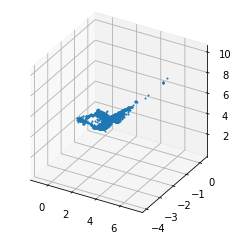

In [280]:
plotvol3();
plt.plot(P[0,:], P[1,:], P[2,:], '.', markersize=2);

In [281]:
if not COLAB:
    walls_pcd = PointCloud(P)
    walls_pcd.transform(SE3.Rx(pi));  # make y-axis upward
    walls_pcd.disp(block=True)
    walls_pcd = walls_pcd.remove_outlier(nb_points=10, radius=0.2)

Remove radius outliers: [========================================] 100%


In [282]:
if not COLAB:
  colors = []
  for m in matches:
    colors.append(walls_l.image[int(m.p1[1]), int(m.p1[0]), :])
  pcd = SE3.Rx(pi) * PointCloud(P, colors=np.array(colors).T)
  pcd.disp()

In [283]:
p1_reproj = camera.project_point(P[:, 0]);
p2_reproj = camera.project_point(P[:, 0], pose=T_1_2);

In [284]:
(p1_reproj - matches[0].p1).T
(p2_reproj - matches[0].p2).T

array([[-0.06476,   -804.6],
       [   804.9,   0.4298]])

In [285]:
bundle = BundleAdjust(camera)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
view0 = bundle.add_view(SE3(), fixed=True);
view1 = bundle.add_view(SE3.Tx(0.3));

In [ ]:
for (Pj, mj) in zip(P[:, ::4].T, matches[::4]):
  landmark = bundle.add_landmark(Pj)             # add vertex
  bundle.add_projection(view0, landmark, mj.p1)  # add edge
  bundle.add_projection(view1, landmark, mj.p2)  # add edge

In [ ]:
bundle

In [ ]:
bundle.plot()

In [ ]:
x = bundle.getstate();
x.shape

In [ ]:
x[6:12]

In [ ]:
x[12:15]

In [ ]:
bundle.errors(x)

p, A, B = camera.derivatives(t, r, P);

In [ ]:
x_new, resid = bundle.optimize(x);

In [ ]:
bundle.setstate(x_new);

In [ ]:
bundle.views[1].pose.printline(orient="camera")

In [ ]:
T_1_2.printline(orient="camera")

In [ ]:
bundle.landmarks[0].P

In [ ]:
e = np.sqrt(bundle.getresidual());
e.shape

In [ ]:
np.median(e, axis=1)

In [ ]:
np.max(e, axis=1)

# 14.4 Dense Stereo Matching


In [ ]:
rocks_l = Image.Read("rocks2-l.png", reduce=2)
rocks_r = Image.Read("rocks2-r.png", reduce=2)

rocks_l.stdisp(rocks_r)

In [ ]:
disparity, *_ = rocks_l.stereo_simple(rocks_r, hw=3, drange=[40, 90]);

In [ ]:
disparity.disp(colorbar=True);

In [ ]:
disparity, similarity, DSI = rocks_l.stereo_simple(rocks_r, hw=3, drange=[40, 90])

In [ ]:
DSI.shape

In [ ]:
np.argmax(DSI, axis=2);

In [ ]:
similarity_values = np.max(DSI, axis=2);

In [ ]:
plt.plot(DSI[439, 138, :], "o-");

## 14.4.1 Peak Refinement


In [ ]:
disparity_refined, A = Image.DSI_refine(DSI)

## 14.4.2 Stereo Failure Modes


### 14.4.2.1 Multiple peaks


### 14.4.2.2 Weak matching


In [ ]:
similarity.disp();

In [ ]:
similarity.choose("blue", similarity < 0.6).disp();

In [ ]:
plt.hist(similarity.view1d(), 100, (0, 1), cumulative=True, density=True);

### 14.4.2.3 Broad peak


### 14.4.2.4 Quantifying Failure Modes


In [ ]:
status = np.ones(disparity.shape);

In [ ]:
U, V = disparity.meshgrid()
status[np.isnan(disparity.image)] = 5   # no similarity computed
status[U <= 90] = 2                     # no overlap
status[similarity.image < 0.6] = 3      # weak match
status[A.image >= -0.1] = 4             # broad peak

In [ ]:
plt.imshow(status);

In [ ]:
(status == 1).sum() / status.size * 100

In [ ]:
disparity_valid = disparity.choose(0, status!=1)

### 14.4.2.5 Slicing the DSI


In [ ]:
Image(DSI[100, :, :].T).disp();

### 14.4.2.6 Summary


### 14.4.2.7 Advanced Stereo Matching


In [ ]:
disparity_BM = rocks_l.stereo_BM(rocks_r, hw=3, drange=[40, 90], speckle=(200, 2))
disparity_BM.disp();

In [ ]:
rocks_l.stereo_SGBM(rocks_r, hw=3, drange=[40, 90], speckle=(200, 2)).disp();

### 14.4.2.8 3D Reconstruction


In [ ]:
di = disparity_BM.image * 2 + 274;

In [ ]:
U, V = disparity_BM.meshgrid();
u0, v0 = disparity.centre;
f = 3740;   # pixels, according to Middlebury website
b = 0.160;  # m, according to Middlebury website
X = b * (U - u0) / di; Y = b * (V - v0) / di; Z = f * b / di;

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, Z)
ax.view_init(-100, -100)

In [ ]:
if not COLAB:
    cam = CentralCamera(f=f, imagesize=rocks_l.shape);
    pcd = PointCloud(Z, image=rocks_l, camera=cam, depth_trunc=1.9)
    pcd *= SE3.Rx(pi);  # make y-axis upward
    pcd.disp()

## 14.4.3 Image Rectification


In [ ]:
walls_l = Image.Read('walls-l.png', reduce=2)
walls_r = Image.Read('walls-r.png', reduce=2)

In [ ]:
sf_l = walls_l.SIFT()
sf_r = walls_r.SIFT()

In [ ]:
matches = sf_l.match(sf_r);

In [ ]:
F, resid = matches.estimate(CentralCamera.points2F, 
                            method="ransac", confidence=0.95);

In [ ]:
H_l, H_r = walls_l.rectify_homographies(matches, F)

In [ ]:
walls_l_rect = walls_l.warp_perspective(H_l)
walls_r_rect = walls_r.warp_perspective(H_r)

In [ ]:
if COLAB:
    walls_l_rect.disp()
    walls_r_rect.disp()
else:
    walls_l_rect.stdisp(walls_r_rect)

In [ ]:
walls_l_rect.stereo_SGBM(walls_r_rect, hw=7, drange=[180, 530], speckle=(50, 2)).disp();

# 14.5 Anaglyphs


In [ ]:
walls_l.anaglyph(walls_r, "rc").disp();

# 14.7 Point Clouds


In [ ]:
if not COLAB:
    bunny_pcd = PointCloud.Read('data/bunny.ply')
    bunny_pcd.disp(block=True)
    pcd = bunny_pcd.voxel_grid(voxel_size=0.01).disp(block=True)
    pcd = bunny_pcd.downsample_voxel(voxel_size=0.01)
    pcd.normals(radius=0.1, max_nn=30)
    pcd.disp(block=True)

## 14.7.1 Fitting a Plane


In [ ]:
if not COLAB:
    pcd = walls_pcd
    plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05, seed=0)
    print(plane)

    print(plane_pcd)

    plane, plane_pcd, pcd = pcd.segment_plane(distance_threshold=0.05, seed=0)
    print(plane)

## 14.7.2 Matching Two Sets of Points


In [ ]:
if not COLAB:
    model = bunny_pcd.downsample_random(0.1, seed=0)

    data = SE3.Trans(0.3, 0.4, 0.5) * SE3.Rz(50, unit="deg") * bunny_pcd.downsample_random(0.05, seed=-1);

    model.paint([0, 0, 1])  # blue
    data.paint([1, 0, 0])   # red
    (model + data).disp(block=True)

    T, status = model.ICP(data, max_correspondence_distance=1, 
                    max_iteration=2000, relative_fitness=0, relative_rmse=0)
    T.printline()

    (model + T.inv() * data).disp(block=True)

# 14.8 Applications


## 14.8.1 Perspective Correction


In [ ]:
notredame = Image.Read("notre-dame.png");
notredame.disp();

In [ ]:
# this won't work with Jupyter, use the pre-picked points defined in the next cell
# picked_points = plt.ginput(4);
# p1 = np.array(picked_points).T;

In [ ]:
# coordinates of 4 points that mark the corners of a rectangle on the face of
# the building
p1 = np.array([
        [ 44.1364,   94.0065,  537.8506,  611.8247], 
        [377.0654,  152.7850,  163.4019,  366.4486]]);

In [ ]:
notredame.disp(block=None);
plot_polygon(p1, filled=True, color="y", alpha=0.4, linewidth=2);
plot_point(p1, "yo");
mn = p1.min(axis=1);
mx = p1.max(axis=1);
p2 = np.array([[mn[0], mn[0], mx[0], mx[0]], [mx[1], mn[1], mn[1], mx[1]]]);
plot_polygon(p2, "k--", close=True, linewidth=2);

In [ ]:
H, _ = CentralCamera.points2H(p1, p2, method="leastsquares")
H

In [ ]:
notredame.warp_perspective(H).disp();

In [ ]:
f = notredame.metadata("FocalLength")

In [ ]:
cam = CentralCamera(imagesize=notredame.shape, f=f/1000, sensorsize=[7.18e-3, 5.32e-3])

In [ ]:
pose, normals = cam.decomposeH(H)
pose.printline(orient="camera")

In [ ]:
normals[0].T

## 14.8.2 Image Mosaicing


In [ ]:
images = ImageCollection("mosaic/aerial2-*.png", mono=True);

In [ ]:
composite = Image.Zeros(2_000, 2_000)

In [ ]:
composite.paste(images[0], (0, 0));
composite.disp();

In [ ]:
next_image = images[1]
sf_c = composite.SIFT()
sf_next= next_image.SIFT()
match = sf_c.match(sf_next);

In [ ]:
H, _ = match.estimate(CentralCamera.points2H, "ransac", confidence=0.99);
H

In [ ]:
tile, topleft, corners = next_image.warp_perspective(H, inverse=True, tile=True)

In [ ]:
composite.paste(tile, topleft, method="blend");
composite.disp();

## 14.8.3 Visual Odometry


In [286]:
import mvtbdata.mvtb_load_image_data

left = ZipArchive("bridge-l.zip", filter="*.pgm", mono=True, dtype="uint8", 
                  maxintval=4095, roi=[20, 750, 20, 480]);
len(left)

already present as /Users/corkep/Dropbox/code/machinevision-toolbox-python/mvtb-data/mvtbdata/images/bridge-l.zip
already present as /Users/corkep/Dropbox/code/machinevision-toolbox-python/mvtb-data/mvtbdata/images/bridge-r.zip


251

In [ ]:
if not COLAB:  # simple animations do not work properly in Jupyter
  for image in left:
    #image.disp(reuse=True, block=None)
    image.disp(reuse=True, fps=10, matplotlib=False)

<span style="background-color:red; font-size:20pt">NOTE</span>

The commented out code produces an animation for a Python script, however, using Jupyter it produces a set of separate images.  Use OpenCV instead (`matplotlib=False`) to display the animation in a separate window.

In [ ]:
for image in left:
   features = image.ORB(nfeatures=20)         # compute ORB features
   image = image.colorize()                   # create RGB image
   features.draw2(image, color='y');          # render ORB features into image
   # image.disp(reuse=True, fps=20, matplotlib=False) # display the image
   # features.plot()                          # overlay the features
   # pause(0.05)

   features.draw2(image, color='y');          # render ORB features into image
   image.disp(reuse=True, fps=20, matplotlib=False) # display the image

In [287]:
right = ZipArchive("bridge-r.zip", mono=True, dtype="uint8", 
                   maxintval=4095, roi=[20, 750, 20, 480]);

           Name: perspective [CentralCamera]
     pixel size: 1.0 x 1.0
           pose: t = 0, 0, 0; rpy/yxz = 0°, 0°, 0°
   principal pt: [   390.3    242.3]
   focal length: [   985.9    985.9]

----------------- 0
114 matches, with 113 (99.1%) inliers
7.32410687763558e-15
----------------- 1
106 matches, with 101 (95.3%) inliers
2.7704543722011948e-15
145 matches, with 145 (100.0%) inliers


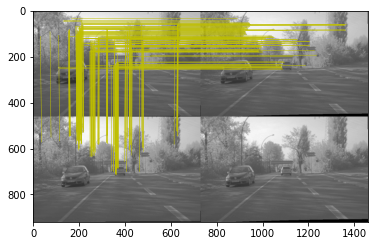

Bundle adjustment cost 204 -- initial
Bundle adjustment cost 31.6 (solved in 0.24 sec)
Bundle adjustment cost 31.1 (solved in 0.22 sec)
Bundle adjustment cost 30.4 (solved in 0.22 sec)
Bundle adjustment cost 29.6 (solved in 0.22 sec)
Bundle adjustment cost 28.6 (solved in 0.22 sec)

 * 5 iterations in 1.2 seconds
 * Final RMS error is 0.52 pixels
----------------- 2
110 matches, with 101 (91.8%) inliers
7.108895957933346e-15
147 matches, with 137 (93.2%) inliers


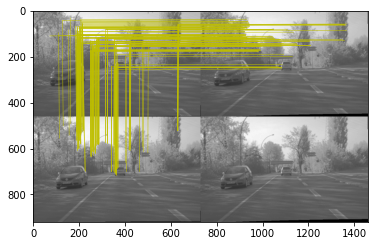

Bundle adjustment cost 162 -- initial
Bundle adjustment cost 23.3 (solved in 0.20 sec)
Bundle adjustment cost 23.1 (solved in 0.20 sec)
Bundle adjustment cost 23 (solved in 0.20 sec)
Bundle adjustment cost 22.7 (solved in 0.21 sec)
Bundle adjustment cost 22.4 (solved in 0.21 sec)

 * 5 iterations in 1.1 seconds
 * Final RMS error is 0.48 pixels
----------------- 3
128 matches, with 120 (93.8%) inliers
7.32410687763558e-15
156 matches, with 150 (96.2%) inliers


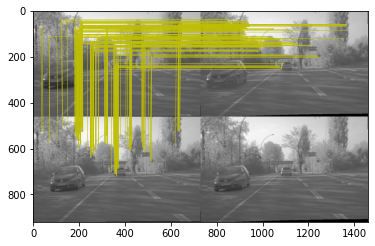

Bundle adjustment cost 257 -- initial
Bundle adjustment cost 39.3 (solved in 0.28 sec)
Bundle adjustment cost 38.6 (solved in 0.29 sec)
Bundle adjustment cost 37.8 (solved in 0.28 sec)
Bundle adjustment cost 36.8 (solved in 0.29 sec)
Bundle adjustment cost 35.4 (solved in 0.28 sec)

 * 5 iterations in 1.5 seconds
 * Final RMS error is 0.51 pixels
----------------- 4
115 matches, with 111 (96.5%) inliers
7.640399661428378e-15
171 matches, with 157 (91.8%) inliers


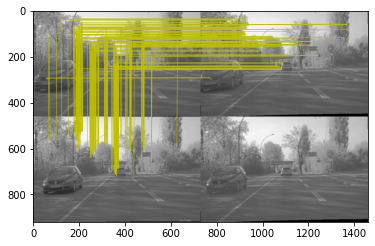

Bundle adjustment cost 181 -- initial
Bundle adjustment cost 35.4 (solved in 0.27 sec)
Bundle adjustment cost 35.3 (solved in 0.28 sec)
Bundle adjustment cost 35.1 (solved in 0.25 sec)
Bundle adjustment cost 34.9 (solved in 0.29 sec)
Bundle adjustment cost 34.6 (solved in 0.29 sec)

 * 5 iterations in 1.5 seconds
 * Final RMS error is 0.55 pixels
----------------- 5
112 matches, with 107 (95.5%) inliers
7.232657794854416e-15
150 matches, with 147 (98.0%) inliers


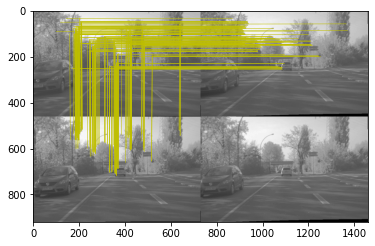

Bundle adjustment cost 279 -- initial
Bundle adjustment cost 31.8 (solved in 0.27 sec)
Bundle adjustment cost 31.7 (solved in 0.27 sec)
Bundle adjustment cost 31.5 (solved in 0.26 sec)
Bundle adjustment cost 31.3 (solved in 0.26 sec)
Bundle adjustment cost 31 (solved in 0.27 sec)

 * 5 iterations in 1.4 seconds
 * Final RMS error is 0.54 pixels
----------------- 6
107 matches, with 100 (93.5%) inliers
7.32410687763558e-15
144 matches, with 144 (100.0%) inliers


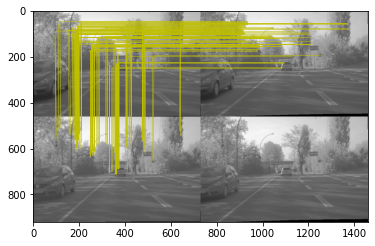

Bundle adjustment cost 281 -- initial


KeyboardInterrupt: 

/Users/corkep/opt/miniconda3/envs/dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2850: UserWarning: Unknown failure executing module: <visodom>
  warn('Unknown failure executing module: <%s>' % mod_name)


In [288]:
%run -m visodom

In [ ]:
ts = np.loadtxt(left.open("timestamps.dat"));

In [ ]:
plt.plot(np.diff(ts));